# Example how to iteratively get more draws (on PyStan)

In [1]:
import pystan # current develop branch (2019-06-28)
import arviz as az # current master branch (2019-06-28)

from tqdm import tqdm_notebook as tqdm
import numpy as np
from IPython import display

In [2]:
az.style.use('arviz-darkgrid')
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

### Helper functions

In [4]:
from notebook_helper import check_limits, update_plot, create_plot

## Setting up the Stan model

https://github.com/stan-dev/example-models/tree/master/misc/gaussian-process

https://mc-stan.org/docs/2_18/stan-users-guide/fit-gp-section.html

## Setting up observed data

In [5]:
stan_data = pystan.read_rdump("./ard_example/gp-fit-ARD.data.R")

In [6]:
stan_data["N"] = int(stan_data["N"])
stan_data["D"] = int(stan_data["D"])

(-2.2047311827956992,
 2.2047311827956992,
 -2.2072847682119208,
 2.2072847682119203)

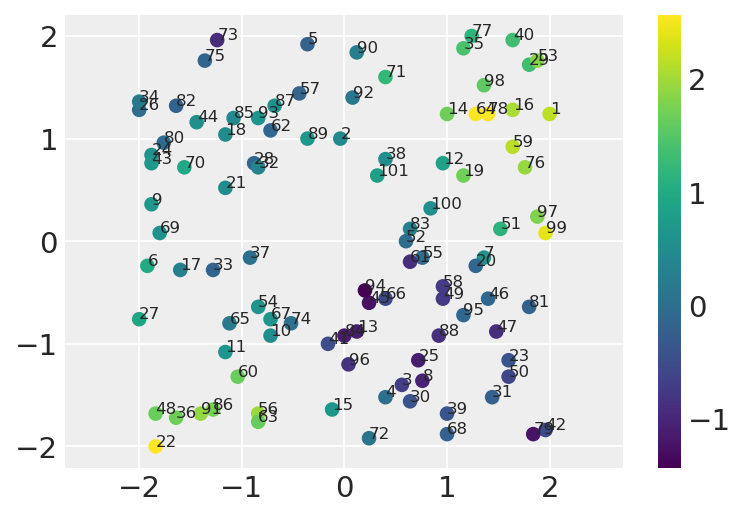

In [7]:
plt.figure(dpi=150)
plt.scatter(*stan_data["x"].T, c=stan_data["y"])
plt.colorbar()
# 1-based indexing
for i, x_ in enumerate(stan_data["x"], 1):
    plt.text(*x_, i, fontsize=8)
plt.axis("equal")

In [8]:
stan_model = pystan.StanModel(file="./ard_example/gp-fit-ARD.stan")

# Iterative sampling

#### Warmup

In [9]:
%%time
nwarmup = 2_000
seed = seed_init = 1454
fit_warmup = stan_model.sampling(data=stan_data,
                                 chains=4,
                                 warmup=nwarmup, 
                                 iter=nwarmup + 1, 
                                 check_hmc_diagnostics=False,
                                 control={"metric" : "diag_e", 
                                          "adapt_delta" : 0.99, 
                                          "max_treedepth" : 13, 
                                          "adapt_engaged" : True,
                                         },
                                 seed=seed,
                                 refresh=50,
                                )

Wall time: 26min 47s


# Tuned parameters

In [10]:
fit_warmup.get_stepsize()

[0.0409255, 0.029912, 0.0464286, 0.0352889]

<BarContainer object of 4 artists>

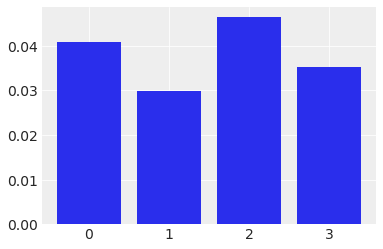

In [11]:
plt.bar(np.arange(4), np.array(fit_warmup.get_stepsize()))

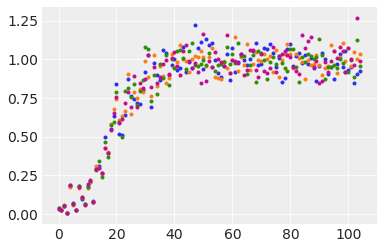

In [12]:
for item in fit_warmup.get_inv_metric():
    plt.scatter(np.arange(len(item)), item, marker='.')

# Setting up init and control

In [13]:
seeds = []
inits = []

# setup inits and tuning
seed += 1
seeds.append(seed)

# take means from warmup
stepsize = fit_warmup.get_stepsize()
inv_metric = fit_warmup.get_inv_metric(as_dict=True)

inits.append(fit_warmup.get_last_position())

control={"stepsize":stepsize, 
         "inv_metric" : inv_metric, 
         "metric" : "diag_e",
         "adapt_engaged" : False,
         "adapt_delta" : 0.99,
         "max_treedepth" : 13,
        }


# Sampling in blocks of 500 draws, 4 chains -->
# - until 40 000 draws
# or
# - ess {bulk, tail} > 500 and rhat < 1.01

- there is also possibility to set accuracy against mcse {mean, sd, quantile}

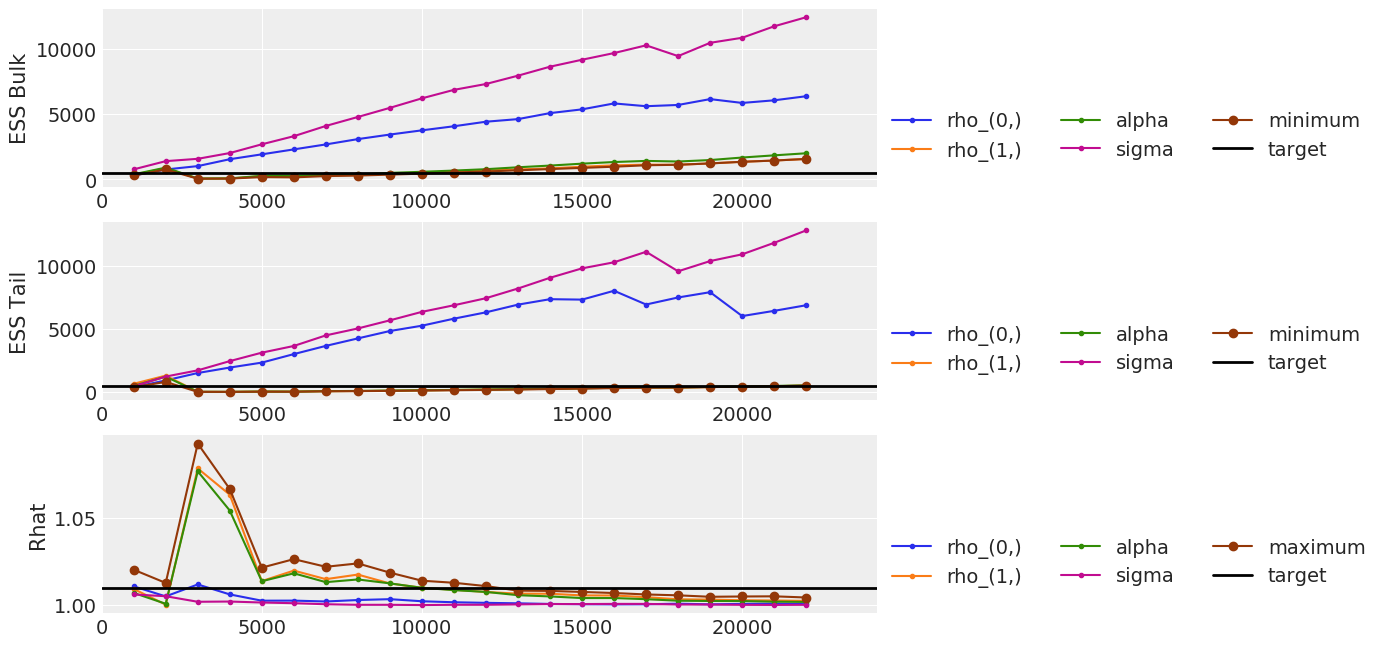

22000/|/ 55%|| 22000/40000 [1:02:24<50:57,  5.89it/s]


Wall time: 1h 2min 29s


In [14]:
%%time

ess_target = 500
rhat_target = 1.01

iter_step = ess_target // 2

total = 40_000//(iter_step*4)
pbar = tqdm(total=total*iter_step*4)

for i in range(total):
    # create control and fit
    fit = stan_model.sampling(data=stan_data,
                              chains=4,
                              init=inits[-1], 
                              control=control, 
                              seed=seed, 
                              warmup=0, 
                              iter=iter_step,
                              check_hmc_diagnostics=False,
                              refresh=50,
                             )

    pbar.update(iter_step*4)
    
    # arviz.InferenceData
    if i == 0:
        idata = az.from_pystan(posterior=fit,
                               posterior_predictive="y_hat", 
                               log_likelihood="log_lik",
                               observed_data=["x", "y"],
                              )
        
        # create plots
        fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,8), dpi=100)
        _, lines_ess_bulk = create_plot(idata, ax1, 
                                        func=az.ess, method="bulk", 
                                        variables=["rho", "alpha", "sigma"], limit=ess_target, 
                                        rule="min", name="ESS Bulk")
        _, lines_ess_tail = create_plot(idata, ax2, 
                                        func=az.ess, method="tail", 
                                        variables=["rho", "alpha", "sigma"], limit=ess_target, 
                                        rule="min", name="ESS Tail")
        _, lines_rhat_rank = create_plot(idata, ax3, 
                                         func=az.rhat, method="rank", 
                                         variables=["rho", "alpha", "sigma"], limit=rhat_target, 
                                         rule="max", name="Rhat")
    else:
        idata_ = az.from_pystan(posterior=fit, 
                                posterior_predictive="y_hat", 
                                log_likelihood="log_lik",
                                observed_data=["x", "y"],
                               )
        idata = az.concat(idata, idata_, dim="draw")
        
        _, lines_ess_bulk = update_plot(idata, ax1, 
                                        func=az.ess, method="bulk", 
                                        lines=lines_ess_bulk, variables=["rho", "alpha", "sigma"])
        _, lines_ess_tail = update_plot(idata, ax2, 
                                        func=az.ess, method="tail", 
                                        lines=lines_ess_tail, variables=["rho", "alpha", "sigma"])
        _, lines_rhat_rank = update_plot(idata, ax3, 
                                         func=az.rhat, method="rank", 
                                         lines=lines_rhat_rank, variables=["rho", "alpha", "sigma"])
    
    #update figures
    display.clear_output(wait=True)
    display.display(plt.gcf())
    display.display(pbar)
    
    # check if limits are satisfied
    if check_limits(idata, ess=ess_target, rhat=rhat_target, mcse=None):
        break

    # update inits and seed
    seed += 1
    seeds.append(seed)
    inits.append(fit.get_last_position())
    
pbar.close()
plt.close(plt.gcf())

# Save to netCDF4 with ArviZ

In [15]:
# save samples (InferenceData) to a compressed netCDF4
idata.to_netcdf("./Stan_inference_data_ARD.nc")

'./Stan_inference_data_ARD.nc'

# Reload data (After cloning, you can start here)

In [16]:
# load data from disc
idata = az.from_netcdf("./Stan_inference_data_ARD.nc")

# Analyze the results

In [17]:
summary = az.summary(idata, var_names=["rho", "alpha", "sigma"], index_origin=1)
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
rho[1],1.391,0.249,0.903,1.842,0.003,0.002,6246.0,5993.0,6357.0,6864.0,1.0
rho[2],1.223,0.197,0.857,1.593,0.006,0.005,1030.0,744.0,1549.0,508.0,1.0
alpha,1.240,0.303,0.742,1.816,0.010,0.008,1002.0,712.0,1983.0,529.0,1.0
sigma,0.340,0.027,0.290,0.391,0.000,0.000,12625.0,12625.0,12415.0,12782.0,1.0


In [18]:
%%time
loo = az.loo(idata, scale="log", pointwise=True)
print(loo)

c:\users\aohartik\github\arviz\arviz\stats\stats.py:442: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 22000 by 101 log-likelihood matrix

         Estimate       SE
elpd_loo   -44.66     5.84
p_loo       18.07        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       94   93.1%
 (0.5, 0.7]   (ok)          6    5.9%
   (0.7, 1]   (bad)         1    1.0%
   (1, Inf)   (very bad)    0    0.0%

Wall time: 1.91 s


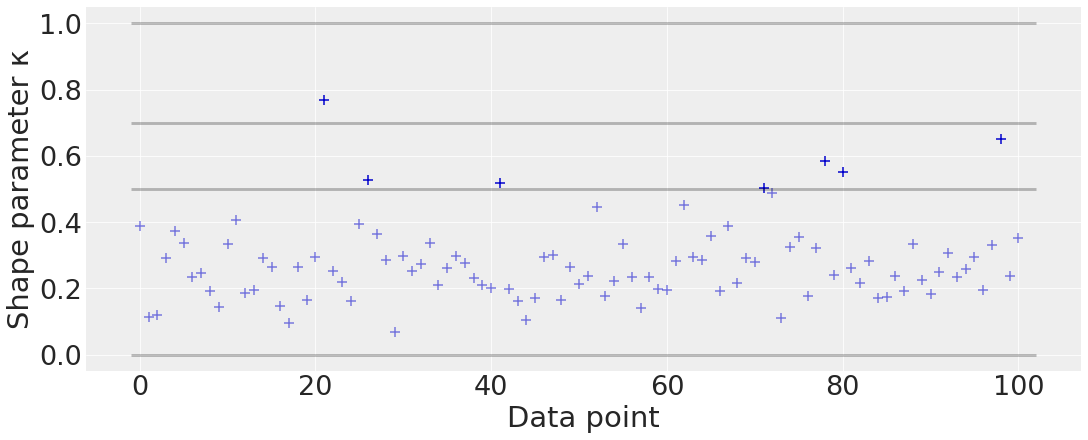

In [19]:
az.plot_khat(loo["pareto_k"], figsize=(15,6), markersize=100)

(-2.2047311827956992,
 2.2047311827956992,
 -2.2072847682119208,
 2.2072847682119203)

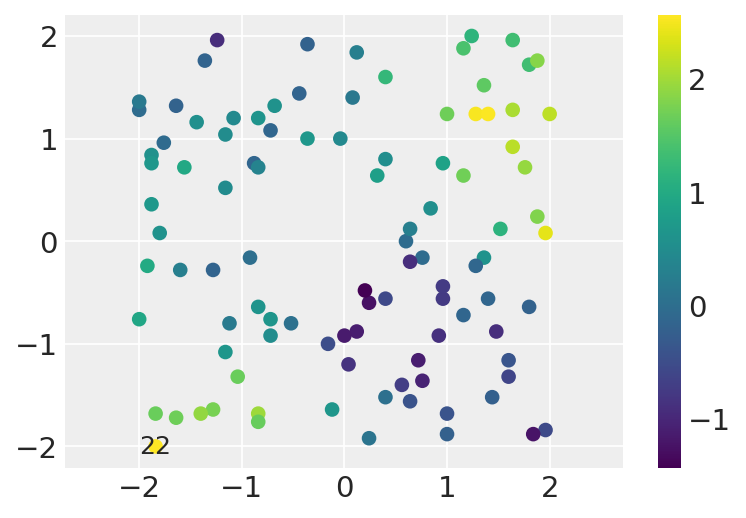

In [20]:
plt.figure(dpi=150)
plt.scatter(*stan_data["x"].T, c=stan_data["y"])
plt.colorbar()
# 1-based indexing
for i, x_ in enumerate(stan_data["x"], 1):
    if i in np.flatnonzero(loo["pareto_k"] > 0.7) + 1:
        plt.text(*x_, i, fontsize=12, 
                 horizontalalignment='center',
                 verticalalignment='center'
                )
plt.axis("equal")

In [21]:
# rounds
len(seeds)

22

In [22]:
# check divergences
int(idata.sample_stats.diverging.sum().values), idata.sample_stats.diverging.size, idata.sample_stats.diverging.sum().values / idata.sample_stats.diverging.size

(147, 22000, 0.006681818181818182)

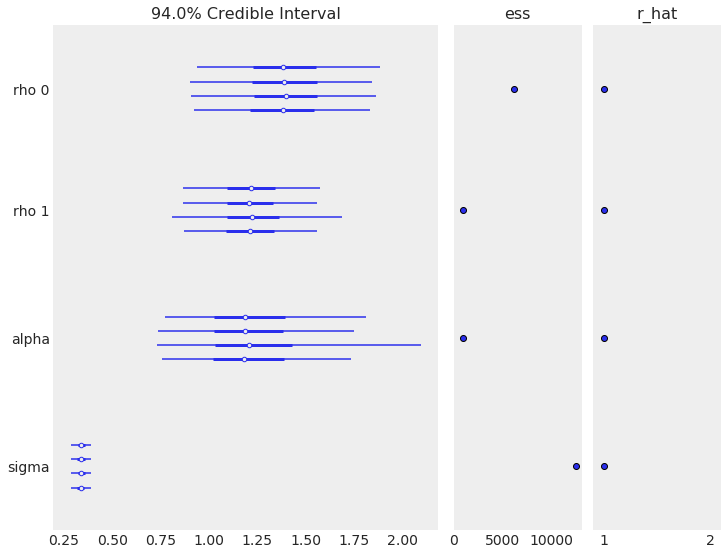

In [23]:
az.plot_forest(idata, var_names=["rho", "alpha", "sigma"], r_hat=True, ess=True);

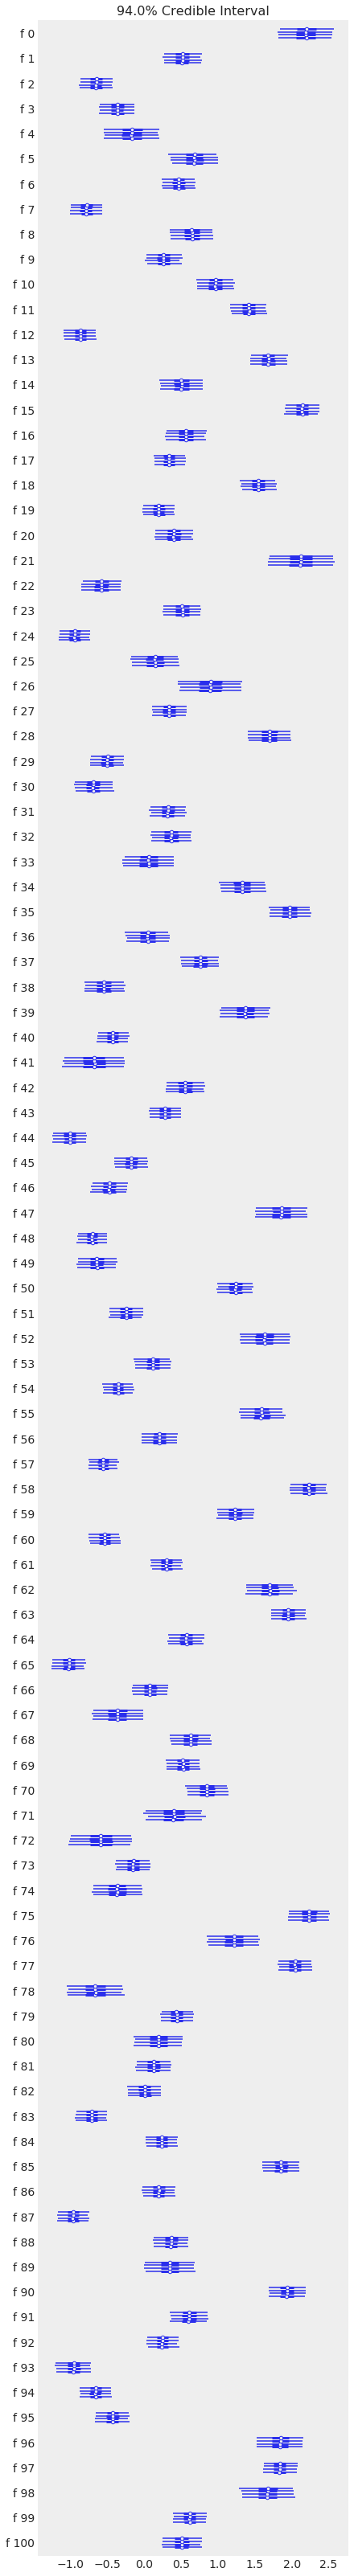

In [24]:
fig, axes = az.plot_forest(idata, var_names=["f"]);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029DB00D1978>,
      dtype=object)

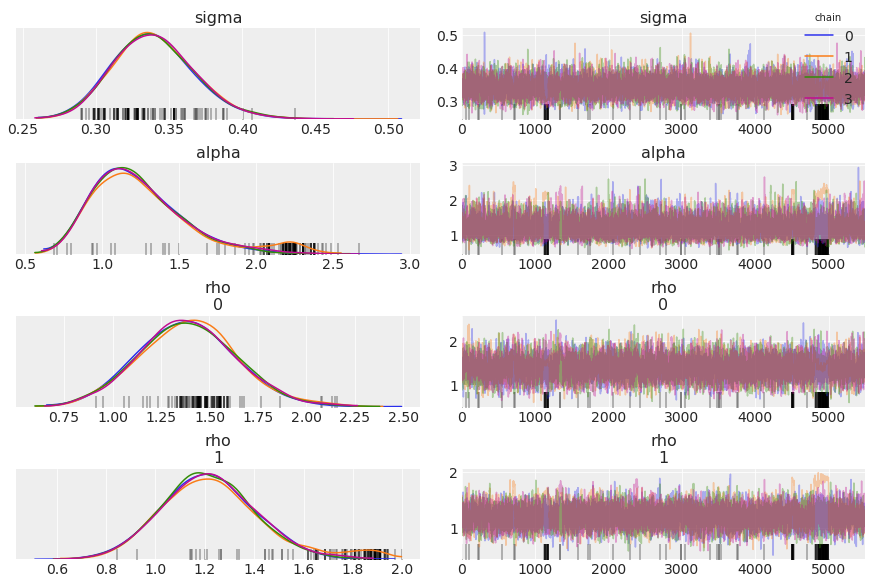

In [25]:
az.plot_trace(idata, var_names=["sigma", "alpha", "rho"], legend=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029DB2B21C88>,
      dtype=object)

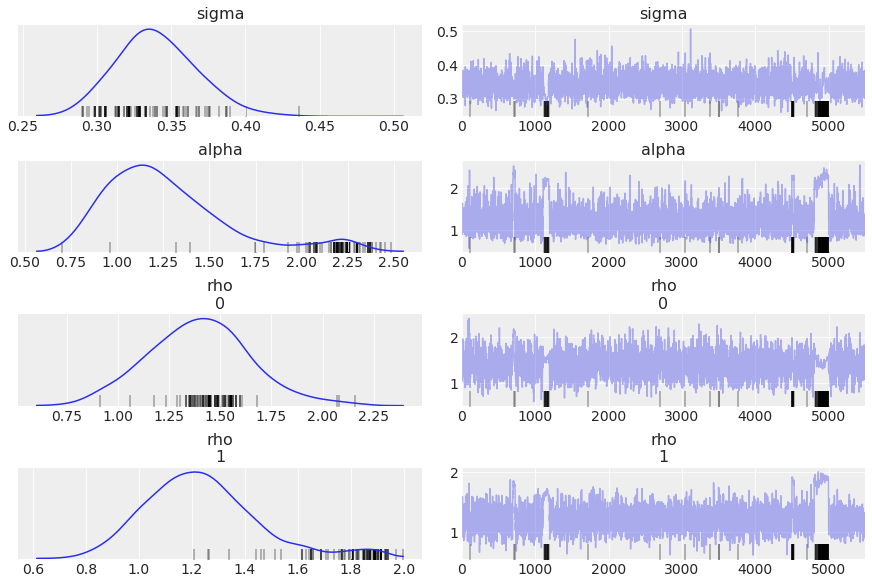

In [26]:
az.plot_trace(idata, var_names=["sigma", "alpha", "rho"], coords={"chain" : [1]})

c:\users\aohartik\github\arviz\arviz\plots\kdeplot.py:384: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)


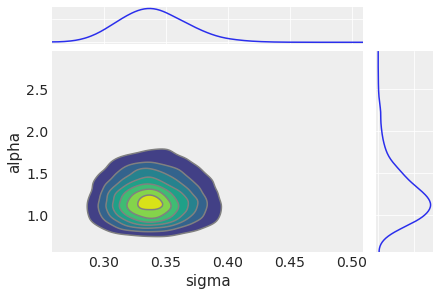

In [27]:
az.plot_joint(idata, ["sigma", "alpha"], kind="kde", contour=True, fill_last=False);

c:\users\aohartik\github\arviz\arviz\plots\kdeplot.py:384: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029DB3EFCB38>,
      dtype=object)

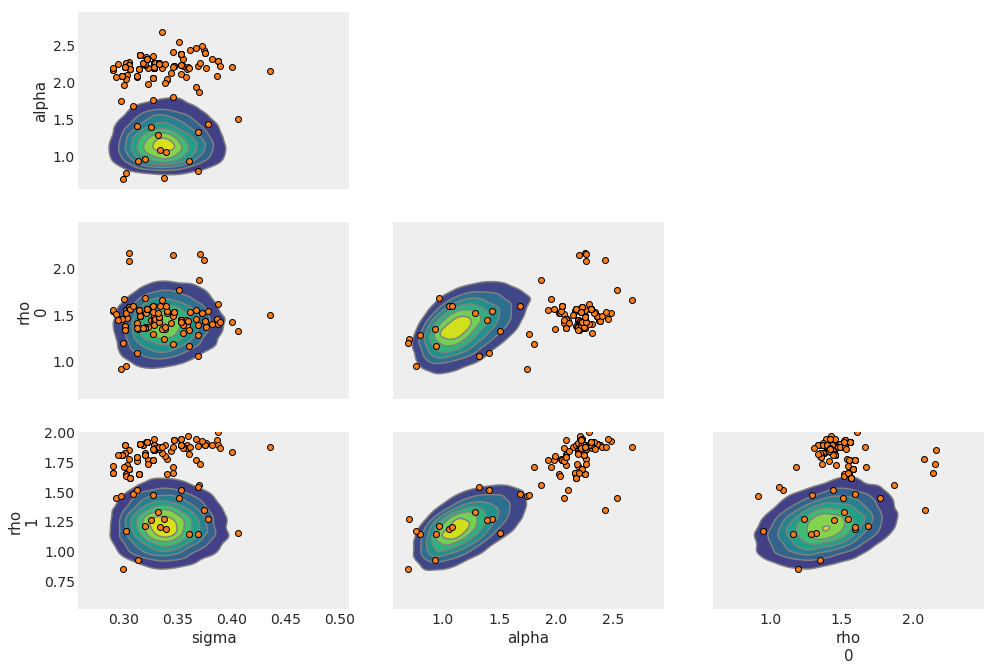

In [28]:
az.plot_pair(idata, ["sigma", "alpha", "rho"], divergences=True, kind="kde", fill_last=False)

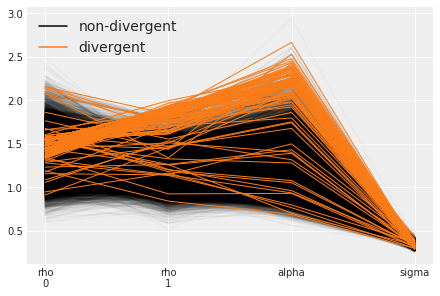

In [29]:
az.plot_parallel(idata, var_names=["rho", "alpha", "sigma"])